In [77]:
import numpy as np
from tensorflow.keras import models,layers,losses,optimizers,initializers,regularizers,constraints
from tensorflow.keras import utils,metrics
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import callbacks
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm

In [78]:
#vocabulary in glove file

glove_file=open('glove.6B.100d.txt','r',encoding='utf8')
vocab_dict=dict()      
for line in glove_file:
    l = line.split()
    words = l[0]
    word_vec = np.asarray(l[1:],dtype=np.float32)
    vocab_dict[words]=word_vec

In [79]:
# processing input file including 
import random
inp=[]
with open('input.txt','r') as f:
    for l in f:
        a=str(l.strip()).lower()
        p=re.sub('\W',' ',a)
        inp.append(p)

def tokenizer(inp):
    token = Tokenizer()
    token.fit_on_texts(inp)
    inp_seq = token.texts_to_sequences(inp)
    return inp_seq,token
inp_seq,token=tokenizer(inp)

lenths = [len(i) for i in inp_seq]
#print(lenths)
from statistics import mode
max_len = max(lenths)
mode_len = mode(lenths)
avg_len = np.mean(np.array(lenths)) #22.01816043898615-avg  13-mode  179-max

pad_inp = sequence.pad_sequences(inp_seq,maxlen=100,dtype=np.int32,padding='pre',truncating='pre') # len=22
vocab_size = len(token.word_index)+1


from sklearn.preprocessing import normalize

normalized_pad_inp = normalize(pad_inp)
#print(pad_inp,normalized_pad_inp)



In [121]:
# input data from another file
stop = stopwords.words('english')
new_inp = []
new_out = []
fin = open('data/train.txt','r')
for line in fin:
    values = line.split(' ')
    new_out.append(values[-1])
    x = values[:-1]
    x = [i for i in x if i not in stop]
    new_inp.append(' '.join(x))
fin.close()    
new_inp_seq,new_token = tokenizer(new_inp)

new_lenths = [len(i) for i in inp_seq]
#print(lenths)

new_max_len = max(new_lenths)
new_mode_len = mode(new_lenths)
new_avg_len = np.mean(np.array(new_lenths))

new_pad_inp = sequence.pad_sequences(new_inp_seq,maxlen=50,dtype=np.int32,padding='pre',truncating='pre') # len=22
new_vocab_size = len(new_token.word_index)+1


from sklearn.preprocessing import normalize

normalized_pad_inp = normalize(new_pad_inp)
print(len(new_out))

16000


In [115]:
# embedding matrix

embedding_matrix=np.zeros([new_vocab_size,100])
for word,i in new_token.word_index.items():
    embedding_value = vocab_dict.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value


In [116]:
# output 

import dataem

y_out=dataem.out
y_out[:10]

array([[0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [122]:
#new output

import pandas as pd
new_out = [i.strip() for i in new_out]
new_output = pd.get_dummies(new_out)

new_output = np.asarray(new_output)
len(new_output)

16000

In [162]:
# creating model

model = models.Sequential()
model.add(layers.Embedding(new_vocab_size,100,weights=[embedding_matrix],input_length=50,trainable=False))
model.add(layers.Conv1D(64,kernel_size=5,padding='valid'))
model.add(layers.LSTM(128,dropout=0.5,recurrent_dropout=0.5))
#model.add(layers.LSTM(128))
model.add(layers.Dropout(0.9))
model.add(layers.Dense(32))
model.add(layers.Dense(6,activation='softmax'))

model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 50, 100)           1506500   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 64)            32064     
_________________________________________________________________
lstm_69 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_70 (Dense)             (None, 6)                 198       
Total params: 1,641,706
Trainable params: 135,206
Non-trainable params: 1,506,500
_____________________________________

In [163]:
# compiling model
opt = optimizers.Adam(learning_rate=0.0001,beta_2=0.98,beta_1=0.9,epsilon=1e-8)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [164]:
# training model
callback = callbacks.EarlyStopping(monitor='loss',patience=3)
fit=model.fit(new_pad_inp,new_output,epochs=50,batch_size=32,verbose=1,validation_split=0.1,callbacks=[callback])

Train on 14400 samples, validate on 1600 samples
Epoch 1/50
14400/14400 [==============================] - 43s 3ms/sample - loss: 1.7497 - accuracy: 0.2801 - val_loss: 1.5477 - val_accuracy: 0.3619
Epoch 2/50
14400/14400 [==============================] - 45s 3ms/sample - loss: 1.6322 - accuracy: 0.3368 - val_loss: 1.5077 - val_accuracy: 0.4025
Epoch 3/50
14400/14400 [==============================] - 44s 3ms/sample - loss: 1.5657 - accuracy: 0.3849 - val_loss: 1.4590 - val_accuracy: 0.4581
Epoch 4/50
14400/14400 [==============================] - 45s 3ms/sample - loss: 1.5157 - accuracy: 0.4217 - val_loss: 1.4007 - val_accuracy: 0.4831
Epoch 5/50
14400/14400 [==============================] - 46s 3ms/sample - loss: 1.4648 - accuracy: 0.4460 - val_loss: 1.3555 - val_accuracy: 0.4938
Epoch 6/50
14400/14400 [==============================] - 45s 3ms/sample - loss: 1.4218 - accuracy: 0.4687 - val_loss: 1.3312 - val_accuracy: 0.5013
Epoch 7/50
14400/14400 [==============================] -

KeyboardInterrupt: 

In [142]:
# testing the model
stop = stopwords.words('english')
new_test_inp = []
new_test_out = []
test_fin = open('data/val.txt','r')
for line in test_fin:
    new_values = line.split(' ')
    new_test_out.append(new_values[-1])
    y = new_values[:-1]
    y = [i for i in y if i not in stop]
    new_test_inp.append(' '.join(y))
test_fin.close()   


new_test_inp_seq,new_test_token = tokenizer(new_test_inp)

new_test_pad_inp = sequence.pad_sequences(new_test_inp_seq,maxlen=50,dtype=np.int32,padding='pre',truncating='pre')

new_test_out = [i.strip() for i in new_test_out]
new_test_output = pd.get_dummies(new_test_out)

new_test_output = np.asarray(new_test_output)
#acc = model.evaluate(new_test_pad_inp,new_test_output)
print(new_test_output.shape,len(new_test_pad_inp))

(2000, 6) 2000


In [166]:
acc=model.evaluate(pad_inp[:2000],new_output[:2000])

2000/2000 [==============================] - 2s 841us/sample - loss: 0.7355 - accuracy: 0.7285


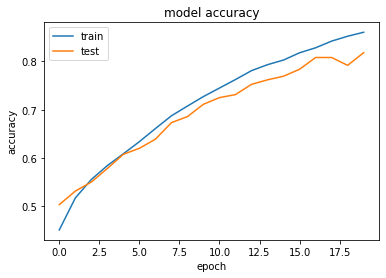

In [131]:
import matplotlib.pyplot as plt
plt.plot(fit.history['accuracy'])
plt.plot(fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

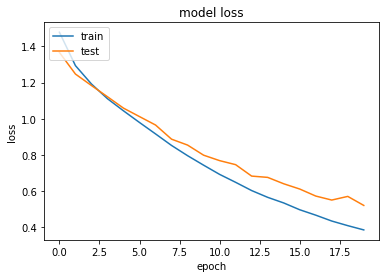

In [132]:
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()